<center><h1 style="font-size:40px;">Image Classification using CNNs</h1></center>

Welcome to the *Fourth* lab for Deep Learning!

In this lab an CNN network to classify RGB images. Image classification refers to classify classes from images. This labs the *dataset* consist of multiple images where each image have a target label for classification.

Good luck!


# NOTE !
## All overfitting models where only trained for 20 epochs to save time, useless to train longer when such obvious signs of overfitting.

In [1]:
!pip install torchvision

In [2]:
import torch
from torch import nn
import os
import imageio.v2 as imageio
import torchvision
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from collections import OrderedDict

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
!python --version

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("No GPU detected.")

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

Python 3.11.5
cuda:0
GPU is available.


### In case you have uploaded a zip file unzip it first. 

Then lets define the ```path``` to the dataset. Make sure you explore the directories of the dataset and get familiar with it!

In [4]:
training_img_dir = "C:/Users/danie/Documents/SKOLA/LAB04/FlyingObjectDataset_10K/FlyingObjectDataset_10K/training"
validation_img_dir = "C:/Users/danie/Documents/SKOLA/LAB04/FlyingObjectDataset_10K/FlyingObjectDataset_10K/validation"
testing_img_dir = "C:/Users/danie/Documents/SKOLA/LAB04/FlyingObjectDataset_10K/FlyingObjectDataset_10K/testing"


Optionally we will start using ```tensorboard```. Use of tensorboard is optional, but we recommend the students to use it. 

Please make sure to read the [doc](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html) to understand how to correctly plot your ```losses``` and ```metrics``` to tensorboard

Ok now that we have the path to the tree different splits, lets start by defining our ```Dataset``` class!
The main two methods we need to define when subclassing ```Dataset``` is ```__getitem__``` and ```__len__```:

In [5]:
class FlyingObjects(torch.utils.data.Dataset):
    def __init__(self, root, fine_grained=False, transform=None):
        super(FlyingObjects, self).__init__()
        self.root = root
        self.transform = transform
        self.fine_grained = fine_grained

        self.images = [os.path.join(self.root, 'image', f) for f in os.listdir(os.path.join(self.root, 'image')) if f.endswith(".png")]
        self.images.sort()

        print("Number of Images Found:", len(self.images))
        
        self.classes = [
            'square_red',
            'square_green',
            'square_blue',
            'square_yellow',
            'triangle_red',
            'triangle_green',
            'triangle_blue',
            'triangle_yellow',
            'circular_red',
            'circular_green',
            'circular_blue',
            'circular_yellow'
        ] if self.fine_grained else [
            'square',
            'triangle',
            'circular',
            'background']
        self.labels = [self.__extract_label(f) for f in self.images]
    

    def get_classes(self):
        return self.classes
    
    
    def __extract_label(self, image_file):
        """Extract label from image_file name"""
        path, img_name = os.path.split(image_file)
        names = img_name.split(".")[0].split("_")

        currLabel = names[1] + "_" + names[2] if self.fine_grained else names[1]

        if currLabel in self.classes:
            label = self.classes.index(currLabel)
        else:
            raise ValueError("ERROR: Label " + str(currLabel) + " is not defined!")
        return label
    
    def __getitem__(self, index):
        # get data
        x = imageio.imread(self.images[index])
        if self.transform:
            x = self.transform(x)
        else:
            x = torch.from_numpy(x)
        x = x.float()
   
        y = self.labels[index]

        return x, y

    def __len__(self):
        return len(self.images)

We can define our transformations. Note that not all transformations are considered ```Data Augmentation```.
The following transformations are used to convert our data to ```Tensor``` and resize our images to the desired size!

In [6]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((64, 64)), 
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((64, 64))
])

# Question 1

Define the three dataloaders for the three splits: ```train```, ```validation``` and ```test``` and visualize data from each split. A function to visualize the image with label is given. You are free to use it or make your own visualizaiton tools.  

In [7]:
def image_with_labels(data, labels, title:str=None, nimages:int=10, nrows:int=2, fig_dimension=1,title_size=10, label_prefix="Label: "):
    """Creates a grid of images with/without labels.

    :param data: tensor": B,W,H,C
    :param labels: tensor":  (Default value = None)
    :param title: str:  (Default value = None)
    :param nimages: int:  (Default value = 10)
    :param nrows: int:  (Default value = 2)
    :param fig_dimension: Default value = 1)
    :param data:"tensor": 
    :param labels:"tensor":  (Default value = None)
    :param title:str:  (Default value = None)
    :param nimages:int:  (Default value = 10)
    :param nrows:int:  (Default value = 2)

    """
    data = data.permute(0,2,3,1)
    image_ratio = data[0].shape[0] /data[0].shape[1]
    if len(data)< nimages:
        nimages = len(data)
 
    columns = math.ceil(nimages/nrows)
    
    if nrows*columns > nimages:
        nrows = math.ceil(nimages/columns)
    
    fig = plt.figure(figsize=(fig_dimension*columns,1.4*fig_dimension*nrows*image_ratio))
    for i in range(0, nimages):
        ax = fig.add_subplot(nrows, columns, i+1)
        ax.imshow(data[i])
        ax.set_xlabel(f"{label_prefix}{labels[i]}") if labels is not None else None
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)

    if labels is None:
        fig.suptitle(title,x=0.5, y=.95, size=title_size) 
        
        fig.subplots_adjust(
            left=0,
            right=0.9,
            top=0.9,
            bottom=0,
            wspace=0.1,
            hspace=-0.45
        )
    else:
        fig.suptitle(title) #,x=0.45, y=.95
        
        fig.subplots_adjust(
            #left=0,
            #right=1,
            top=0.9,#+((nrows-1)*0.045),
            #bottom=0,
            wspace=0,
            #hspace=0
        )
        
    #plt.tight_layout(h_pad=0,w_pad=0)
    fig.tight_layout(pad=0, h_pad=0,w_pad=0)
    plt.show()

Number of Images Found: 10817
Number of Images Found: 2241
Number of Images Found: 2220
data points: train:10817 valid:2241 test:2220
nr of batches: train:339 valid:71 test:70
nr of classes: 
 train: ['square', 'triangle', 'circular', 'background'] 
 valid: ['square', 'triangle', 'circular', 'background'] 
 test: ['square', 'triangle', 'circular', 'background']
Number of unique labels: 3


C:\Users\danie\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


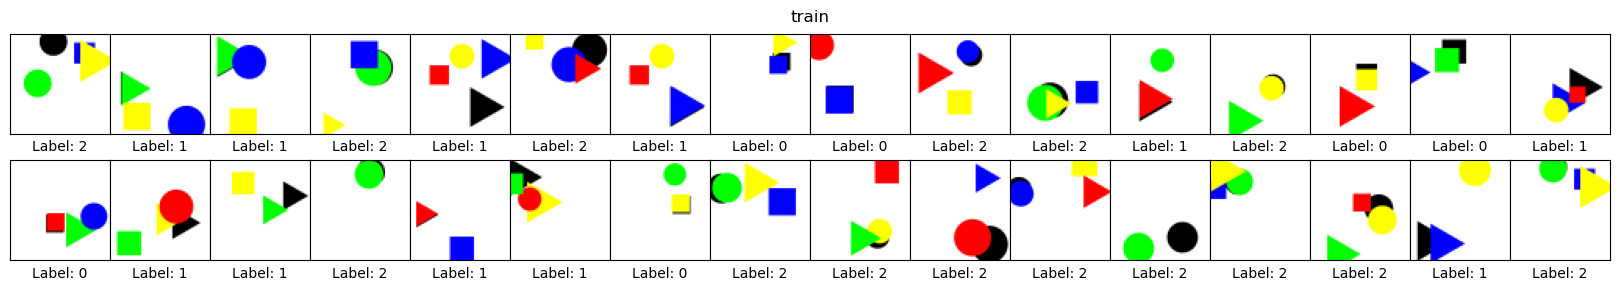

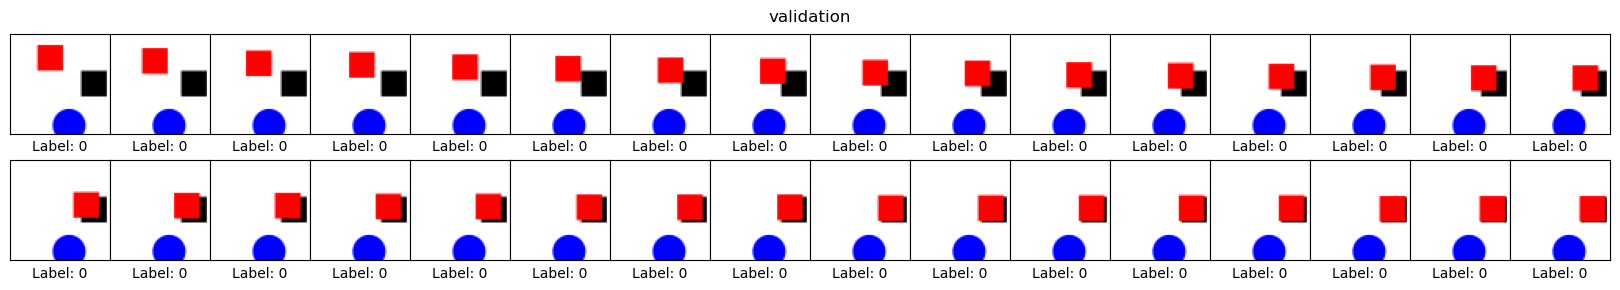

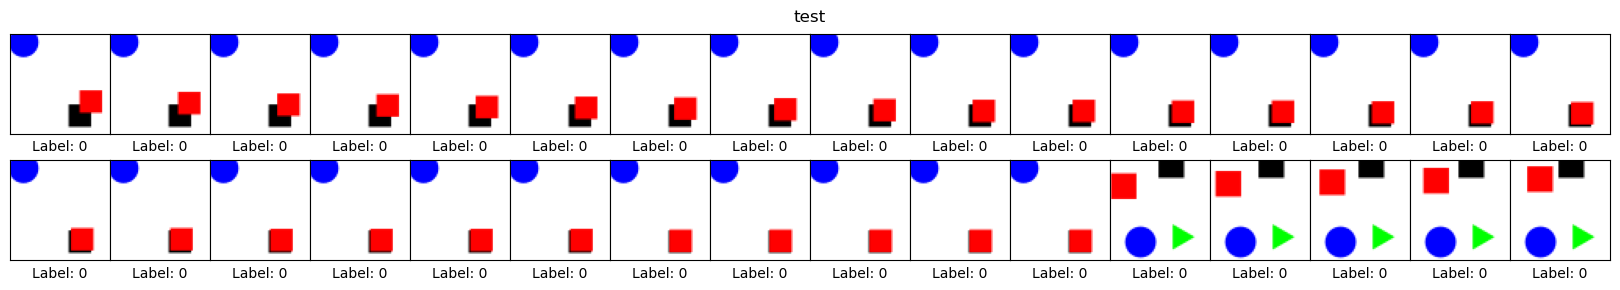

In [8]:
# Your code here 

training_set = FlyingObjects(training_img_dir, fine_grained=False, transform=train_transform)
validation_set = FlyingObjects(validation_img_dir, fine_grained=False, transform=train_transform)
testing_set = FlyingObjects(testing_img_dir, fine_grained=False, transform=train_transform)

print(f"data points: train:{len(training_set)} valid:{len(validation_set)} test:{len(testing_set)}")

train_loader = DataLoader(training_set, batch_size=32, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False)
test_loader = DataLoader(testing_set, batch_size=32, shuffle=False)

print(f"nr of batches: train:{len(train_loader)} valid:{len(val_loader)} test:{len(test_loader)}")

print("nr of classes:", 
      "\n train:", training_set.get_classes(),
      "\n valid:", validation_set.get_classes(),
      "\n test:", testing_set.get_classes())

labels = training_set.labels

unique_labels = set(labels)

num_unique_labels = len(unique_labels)

print("Number of unique labels:", num_unique_labels)

for loader, name in zip([train_loader, val_loader, test_loader], ["train", "validation", "test"]):
    for images, labels in loader:
        image_with_labels(images, labels, title=name, nimages=32)
        break

## Let's start with a very simple network

## We can see in the images and labels above, that this is what the labels mean:

### Label 0: Image has 2 squares in it.
### Label 1: Image has 2 triangles in it.
### Label 2: Image has 2 circles in it.

In [9]:
class SimpleModel(torch.nn.Module):
    def __init__(self,num_channels, num_classes, input_shape=(64,64)):
        super(SimpleModel,self).__init__()
        self.conv_layer1 = self._conv_layer_set(num_channels, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(64*input_shape[1]//4*input_shape[1]//4, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.5)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv',nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)),
            ('leakyrelu',nn.LeakyReLU()),
            ('maxpool',nn.MaxPool2d(2)),
        ]))
        return conv_layer
    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
       
        out = out.view(out.size(0), -1)

        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out

# Question 2

Get inspired on the code you did on the previous lab and create your ```train function```. It might be useful to think about having a ```predict``` function too. Check the code of the previous lab if you need ideas!

Do not forget, to train you need an ```optimizer```, ```loss function``` and an instance of your ```model```! If you need more inspiration check [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)!

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, num_classes=3, lr_dropout_prob=0.1):
    model = model.to(device)
    train_losses = []
    val_losses = []
    val_accuracies = []    
    max_val_accuracy = 0.0  
    best_model_path = 'best_model.pth'

    print("Data:", len(train_loader.dataset))
    print("Epochs:", num_epochs)
    print("Start of training.")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct_train = 0  
        total_train = 0    

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()

            if np.random.rand() > lr_dropout_prob:
                optimizer.step()

            epoch_loss += loss.item()

            _, predicted_labels = torch.max(outputs, 1)
            correct_train += (predicted_labels == labels).sum().item()
            total_train += labels.size(0)

        average_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(average_loss)
        train_accuracy = (correct_train / total_train) * 100

        model.eval()
        val_loss = 0.0
        correct_val = 0   
        total_val = 0    

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(val_loader):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted_labels = torch.max(outputs, 1)
                correct_val += (predicted_labels == labels).sum().item()
                total_val += labels.size(0)

        average_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(average_val_loss)
        val_accuracy = (correct_val / total_val) * 100
        val_accuracies.append(val_accuracy)

        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"New maximum validation accuracy: {max_val_accuracy:.2f}%, model saved at {best_model_path}")

        print(f"{epoch + 1}/{num_epochs} --> Training Loss / per sample = {average_loss:.10f}, Validation Loss / per sample = {average_val_loss:.10f}, Validation Accuracy = {val_accuracy:.2f}%")

    print("End of training.")
    print("Highest Validation Accuracy:", max_val_accuracy)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Validation Losses over {num_epochs} epochs')
    plt.gca().set_facecolor('black')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title(f'Validation Accuracy over {num_epochs} epochs')
    plt.gca().set_facecolor('black')
    plt.show()


# Question 3

Now that you have your train function. Train the network until it overfits. Which ```hyperparameters``` allowed you to overfit?

To help you visualize the results we provide a ```confusion matrix function```. 

## Answer:
The parameters that allowed me to overfit was the learning rate as well as the batch size. the overfitting is prooved by the confusion matrixes.

In [11]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
import numpy as np

In [12]:
def matrix(loader, net, classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    y_pred = []
    y_true = []
    
    # iterate over test data
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to the same device as the model

        output = net(inputs)  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # Save Truth
 
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=classes)
    disp.plot()

Data: 10817
Epochs: 20
Start of training.


C:\Users\danie\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


New maximum validation accuracy: 39.40%, model saved at best_model.pth
1/20 --> Training Loss / per sample = 0.0124481287, Validation Loss / per sample = 0.0809613574, Validation Accuracy = 39.40%
New maximum validation accuracy: 44.53%, model saved at best_model.pth
2/20 --> Training Loss / per sample = 0.0006415421, Validation Loss / per sample = 0.0966718755, Validation Accuracy = 44.53%
3/20 --> Training Loss / per sample = 0.0001617242, Validation Loss / per sample = 0.1253110414, Validation Accuracy = 41.14%
4/20 --> Training Loss / per sample = 0.0001518392, Validation Loss / per sample = 0.1290966813, Validation Accuracy = 42.53%
New maximum validation accuracy: 48.46%, model saved at best_model.pth
5/20 --> Training Loss / per sample = 0.0004867663, Validation Loss / per sample = 0.1169770631, Validation Accuracy = 48.46%
6/20 --> Training Loss / per sample = 0.0003319854, Validation Loss / per sample = 0.1160559711, Validation Accuracy = 48.01%
7/20 --> Training Loss / per sa

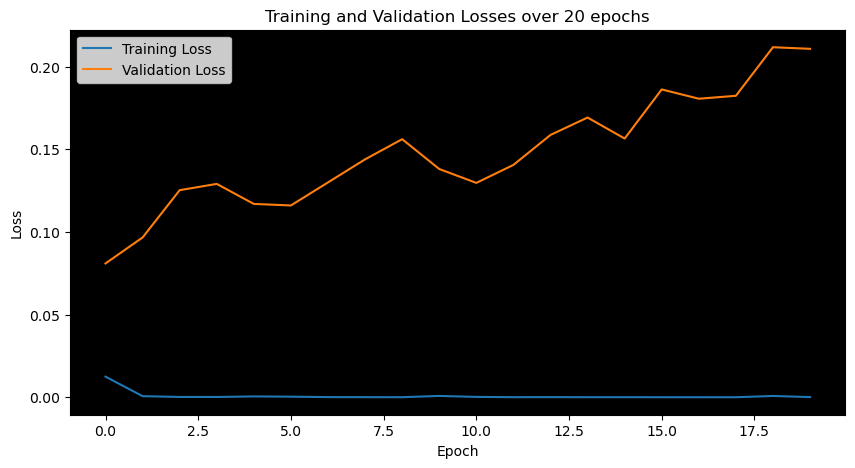

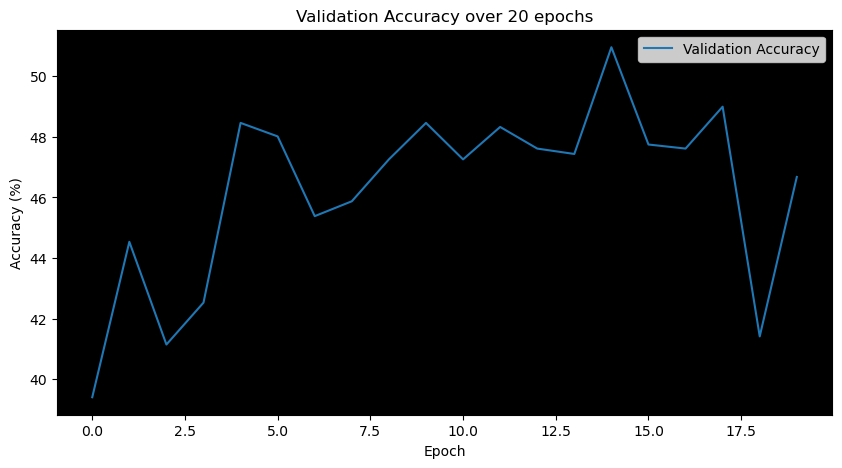

In [13]:
import torch.optim as optim
model1 = SimpleModel(num_channels=3, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

train(model1, train_loader, val_loader, criterion, optimizer, num_epochs=20)

In [14]:
model1.load_state_dict(torch.load("best_model.pth"))
model1.eval()

SimpleModel(
  (conv_layer1): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=16384, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

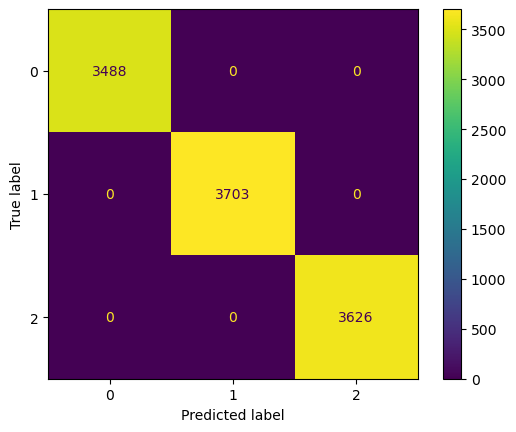

In [15]:
matrix(train_loader, model1,['0', '1', '2'])

C:\Users\danie\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


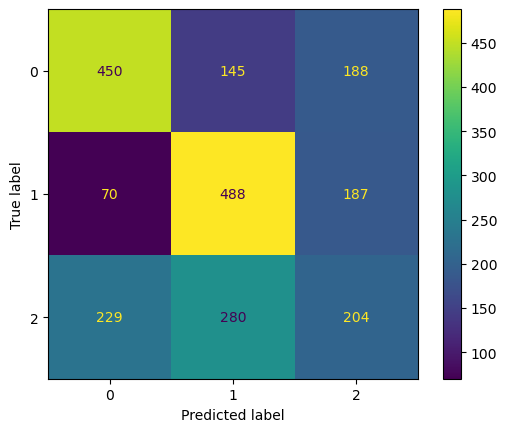

In [16]:
matrix(val_loader, model1, ['0', '1', '2'])

C:\Users\danie\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


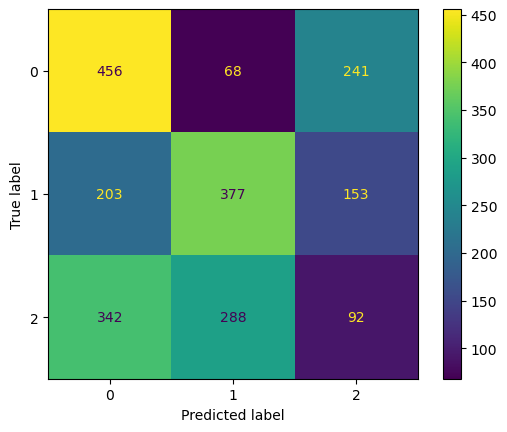

In [17]:
matrix(test_loader, model1,['0', '1', '2'])

# Question 4
Go through the [doc](https://pytorch.org/vision/stable/transforms.html) about data augmentation transformations and use some (Try at least 5 augmentations) in your pipeline. Did the ones you try improve your model? Why? 

Along with ```torchvision``` you can also expore ```https://albumentations.ai/``` for advanced augmentation. 

## Answer:
Yes, the augmentation made the model not overfit and makes it actually learn from the data. All of them worked really well for me, as seen below.


In [18]:
from torchvision import transforms
from PIL import Image

train_transform_augmentation = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.RandomVerticalFlip(p=0.1),
    torchvision.transforms.RandomHorizontalFlip(p=0.1),
    torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    torchvision.transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.5, 2)), 
    torchvision.transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)), 
])

train_dataset_augmented = FlyingObjects(root=training_img_dir, fine_grained=False, transform=train_transform_augmentation)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)
print("Train Dataset Length:", len(train_dataset_augmented))

Number of Images Found: 10817
Train Dataset Length: 10817


Data: 10817
Epochs: 50
Start of training.


C:\Users\danie\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


New maximum validation accuracy: 38.51%, model saved at best_model.pth
1/50 --> Training Loss / per sample = 0.0334362715, Validation Loss / per sample = 0.0374493544, Validation Accuracy = 38.51%
2/50 --> Training Loss / per sample = 0.0305164591, Validation Loss / per sample = 0.0373308255, Validation Accuracy = 37.13%
New maximum validation accuracy: 46.94%, model saved at best_model.pth
3/50 --> Training Loss / per sample = 0.0285933438, Validation Loss / per sample = 0.0328050538, Validation Accuracy = 46.94%
New maximum validation accuracy: 55.96%, model saved at best_model.pth
4/50 --> Training Loss / per sample = 0.0239629420, Validation Loss / per sample = 0.0338961668, Validation Accuracy = 55.96%
New maximum validation accuracy: 68.36%, model saved at best_model.pth
5/50 --> Training Loss / per sample = 0.0192074429, Validation Loss / per sample = 0.0226479810, Validation Accuracy = 68.36%
6/50 --> Training Loss / per sample = 0.0159193467, Validation Loss / per sample = 0.0

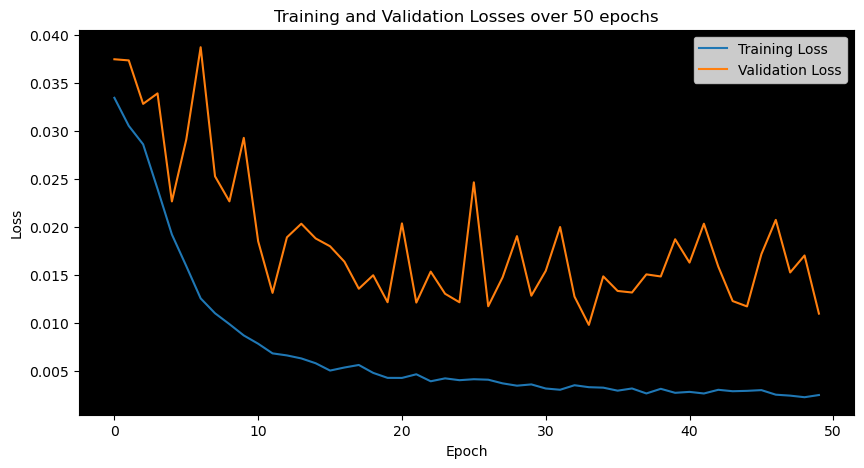

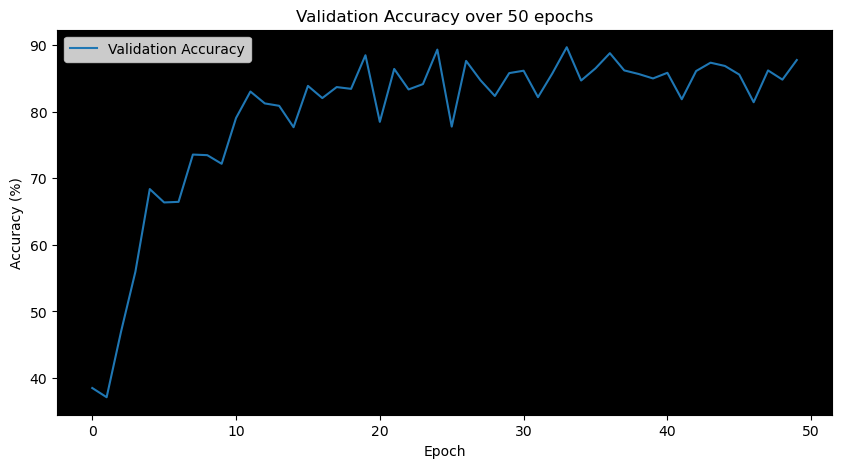

In [19]:
model2 = SimpleModel(num_channels=3, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

train(model2, train_loader_augmented, val_loader, criterion, optimizer, num_epochs=50)

In [20]:
model2.load_state_dict(torch.load("best_model.pth"))
model2.eval()

SimpleModel(
  (conv_layer1): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=16384, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

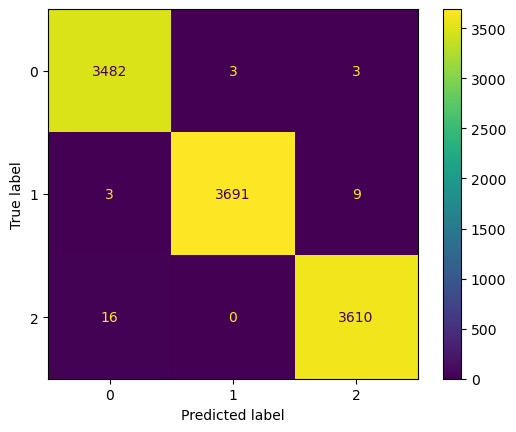

In [21]:
matrix(train_loader, model2, ['0', '1', '2'])

C:\Users\danie\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


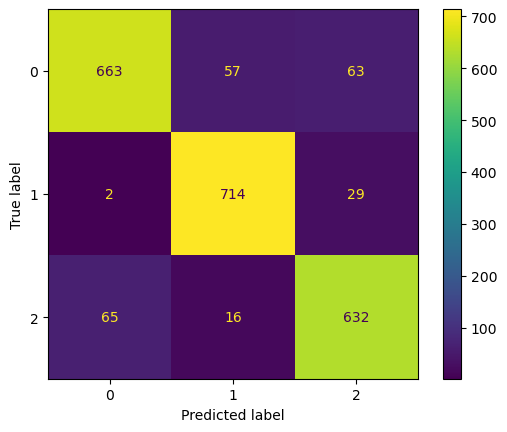

In [22]:
matrix(val_loader, model2, ['0', '1', '2'])

C:\Users\danie\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


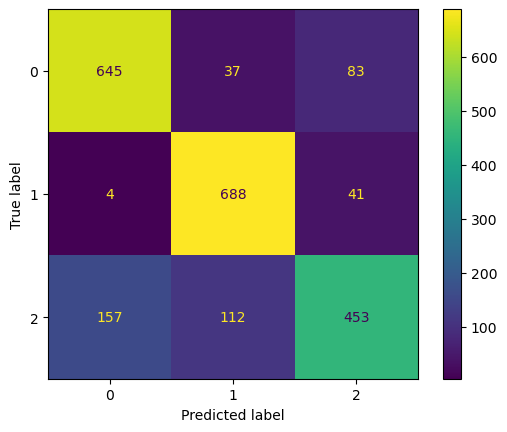

In [23]:
matrix(test_loader, model2, ['0', '1', '2'])

# Question 5

Redo the previous questions with an image size of ```128x128```. Make sure to note what changed and why. If you decided to use tensorboard, compare both versions on ```Tensorboard``` plots.

## Answer:
The model still overfits, however the augmentation fixes that, and now the model achieved an accuracy of 94% instead of 89% compared to question 4, which is reasonable since now we have 128x128 images instead of 64x64 images, meaning that there is better quality of the images for the model.

In [24]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128)), 
])

In [25]:
# Your code here 

training_set = FlyingObjects(training_img_dir, fine_grained=False, transform=train_transform)
validation_set = FlyingObjects(validation_img_dir, fine_grained=False, transform=train_transform)
testing_set = FlyingObjects(testing_img_dir, fine_grained=False, transform=train_transform)

print(f"data points: train:{len(training_set)} valid:{len(validation_set)} test:{len(testing_set)}")

train_loader = DataLoader(training_set, batch_size=32, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False)
test_loader = DataLoader(testing_set, batch_size=32, shuffle=False)

print(f"nr of batches: train:{len(train_loader)} valid:{len(val_loader)} test:{len(test_loader)}")

print("nr of classes:", 
      "\n train:", training_set.get_classes(),
      "\n valid:", validation_set.get_classes(),
      "\n test:", testing_set.get_classes())

labels = training_set.labels

unique_labels = set(labels)

num_unique_labels = len(unique_labels)

print("Number of unique labels:", num_unique_labels)

Number of Images Found: 10817
Number of Images Found: 2241
Number of Images Found: 2220
data points: train:10817 valid:2241 test:2220
nr of batches: train:339 valid:71 test:70
nr of classes: 
 train: ['square', 'triangle', 'circular', 'background'] 
 valid: ['square', 'triangle', 'circular', 'background'] 
 test: ['square', 'triangle', 'circular', 'background']
Number of unique labels: 3


In [26]:
class SimpleModel(torch.nn.Module):
    def __init__(self,num_channels, num_classes, input_shape=(128,128)):
        super(SimpleModel,self).__init__()
        self.conv_layer1 = self._conv_layer_set(num_channels, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(64*input_shape[1]//4*input_shape[1]//4, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.5)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv',nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)),
            ('leakyrelu',nn.LeakyReLU()),
            ('maxpool',nn.MaxPool2d(2)),
        ]))
        return conv_layer
    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
       
        out = out.view(out.size(0), -1)

        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out

Data: 10817
Epochs: 20
Start of training.
New maximum validation accuracy: 39.67%, model saved at best_model.pth
1/20 --> Training Loss / per sample = 0.0111526499, Validation Loss / per sample = 0.0905429542, Validation Accuracy = 39.67%
New maximum validation accuracy: 44.09%, model saved at best_model.pth
2/20 --> Training Loss / per sample = 0.0003133790, Validation Loss / per sample = 0.1101422018, Validation Accuracy = 44.09%
3/20 --> Training Loss / per sample = 0.0000817805, Validation Loss / per sample = 0.1367019803, Validation Accuracy = 37.80%
4/20 --> Training Loss / per sample = 0.0000622734, Validation Loss / per sample = 0.1449565234, Validation Accuracy = 39.71%
5/20 --> Training Loss / per sample = 0.0000780177, Validation Loss / per sample = 0.1429107952, Validation Accuracy = 42.12%
6/20 --> Training Loss / per sample = 0.0001474732, Validation Loss / per sample = 0.1729725752, Validation Accuracy = 38.24%
7/20 --> Training Loss / per sample = 0.0000135508, Validati

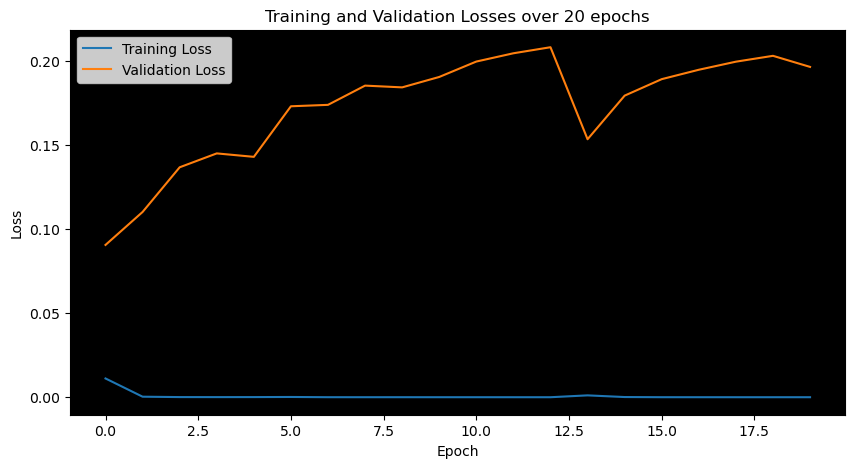

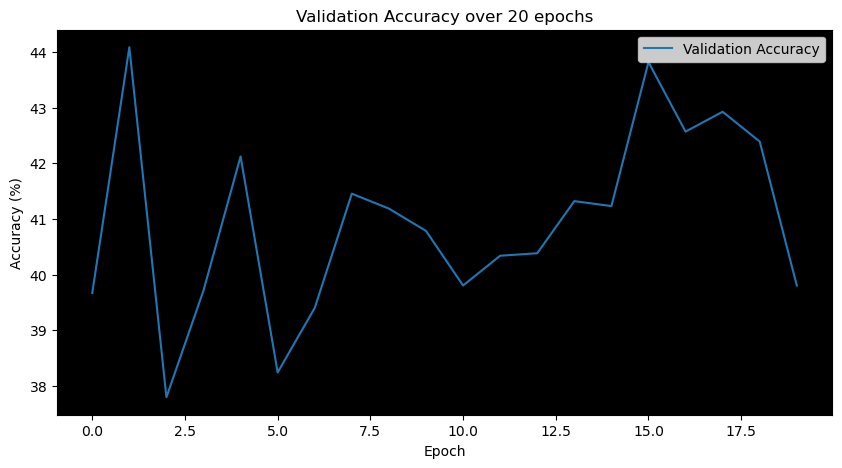

In [27]:
import torch.optim as optim
model3 = SimpleModel(num_channels=3, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)

train(model3, train_loader, val_loader, criterion, optimizer, num_epochs=20)

In [28]:
model3.load_state_dict(torch.load("best_model.pth"))
model3.eval()

SimpleModel(
  (conv_layer1): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=65536, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

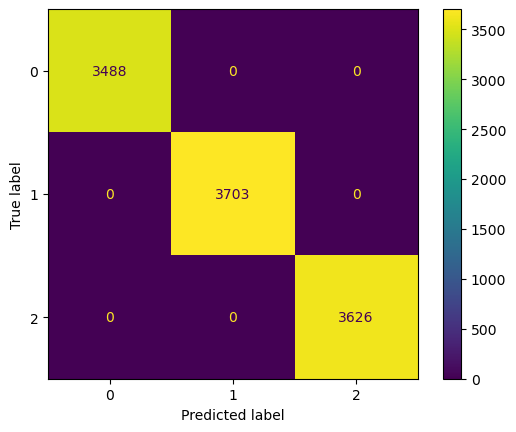

In [29]:
matrix(train_loader, model3, ['0', '1', '2'])

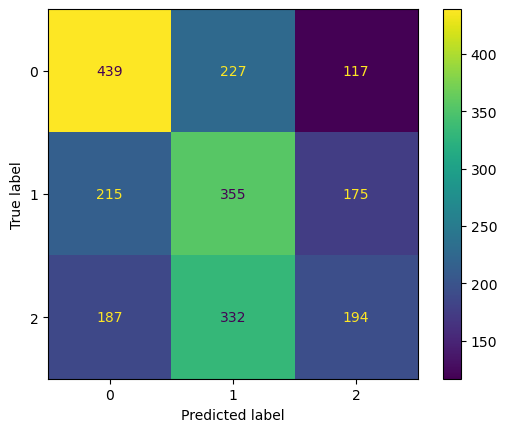

In [30]:
matrix(val_loader, model3, ['0', '1', '2'])

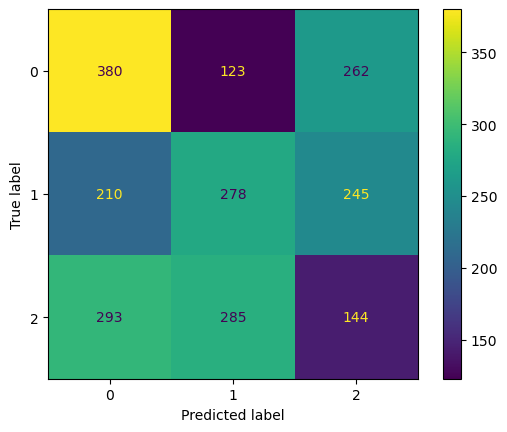

In [31]:
matrix(test_loader, model3, ['0', '1', '2'])

In [32]:
from torchvision import transforms
from PIL import Image

train_transform_augmentation = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.RandomVerticalFlip(p=0.1),
    torchvision.transforms.RandomHorizontalFlip(p=0.1),
    torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    torchvision.transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.5, 2)), 
    torchvision.transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)), 
])

train_dataset_augmented = FlyingObjects(root=training_img_dir, fine_grained=False, transform=train_transform_augmentation)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)
print("Train Dataset Length:", len(train_dataset_augmented))

Number of Images Found: 10817
Train Dataset Length: 10817


Data: 10817
Epochs: 50
Start of training.
New maximum validation accuracy: 35.70%, model saved at best_model.pth
1/50 --> Training Loss / per sample = 0.0341957524, Validation Loss / per sample = 0.0387941912, Validation Accuracy = 35.70%
New maximum validation accuracy: 39.27%, model saved at best_model.pth
2/50 --> Training Loss / per sample = 0.0308352895, Validation Loss / per sample = 0.0391708936, Validation Accuracy = 39.27%
New maximum validation accuracy: 48.59%, model saved at best_model.pth
3/50 --> Training Loss / per sample = 0.0285136403, Validation Loss / per sample = 0.0328695947, Validation Accuracy = 48.59%
New maximum validation accuracy: 63.01%, model saved at best_model.pth
4/50 --> Training Loss / per sample = 0.0230098043, Validation Loss / per sample = 0.0274345353, Validation Accuracy = 63.01%
New maximum validation accuracy: 72.74%, model saved at best_model.pth
5/50 --> Training Loss / per sample = 0.0184980517, Validation Loss / per sample = 0.0220344420, Va

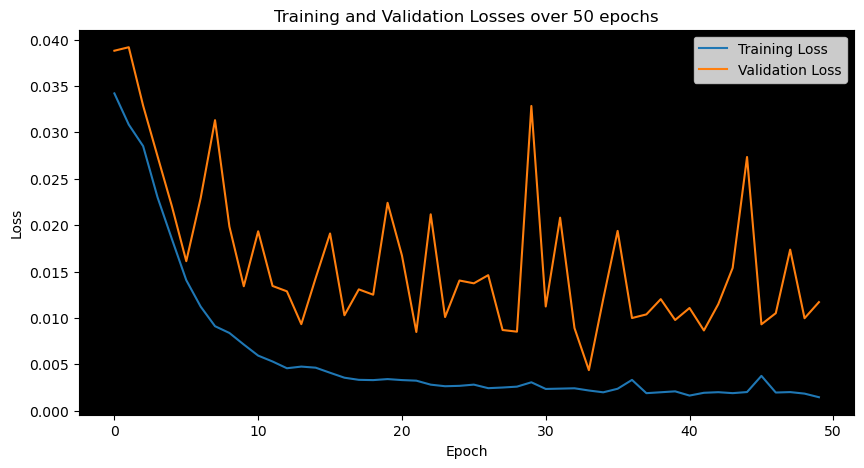

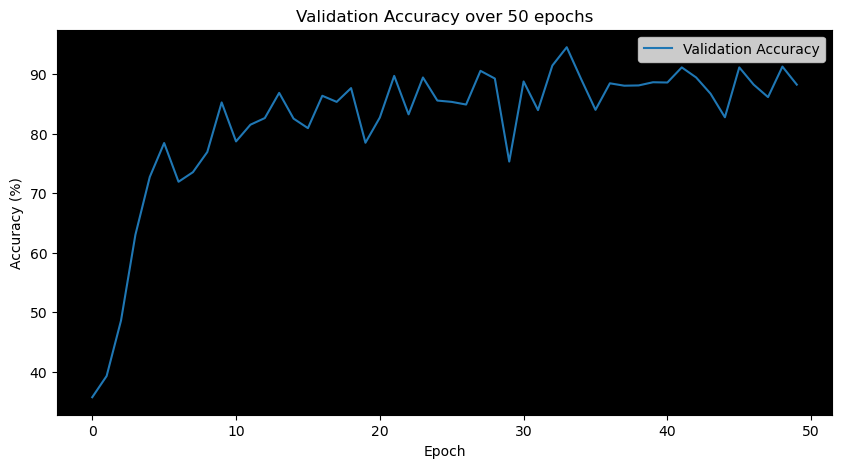

In [33]:
model4 = SimpleModel(num_channels=3, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr=0.001)

train(model4, train_loader_augmented, val_loader, criterion, optimizer, num_epochs=50)

In [34]:
model4.load_state_dict(torch.load("best_model.pth"))
model4.eval()

SimpleModel(
  (conv_layer1): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=65536, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

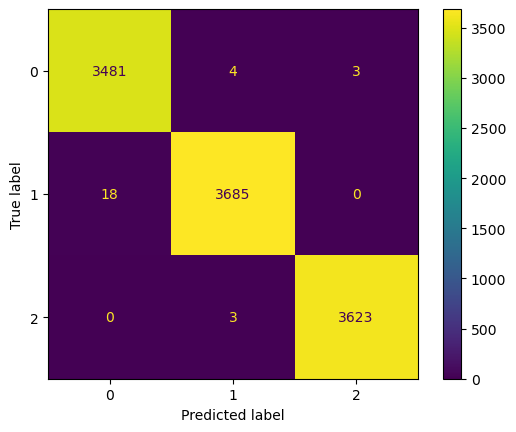

In [35]:
matrix(train_loader, model4, ['0', '1', '2'])

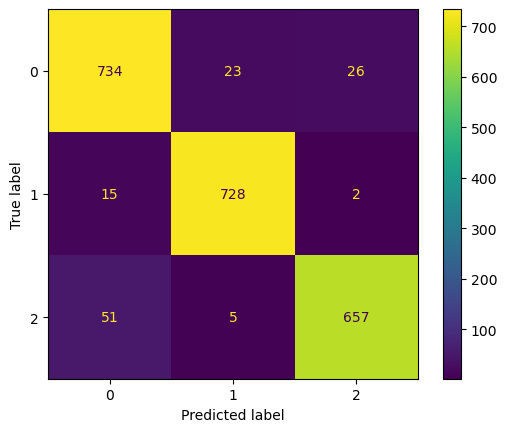

In [36]:
matrix(val_loader, model4, ['0', '1', '2'])

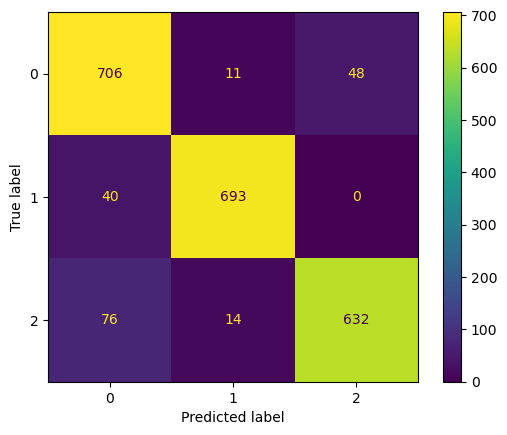

In [37]:
matrix(test_loader, model4, ['0', '1', '2'])

# Question 6

Once you have a good model for ```128x128``` without ```fine grain``` redo the experiments with ```fine grain```. How did the performance change? And why?

## Answer:
The performance changed since there now exists 12 classes instead of 3. thereby the overfitting getting a really low accuracy of about 20%, however when training with augmentation, it actually got really good results still when looking at the confusion matrixes as well as the acccuracy plots.

In [38]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128)), 
])

In [39]:
# Your code here 

training_set = FlyingObjects(training_img_dir, fine_grained=True, transform=train_transform)
validation_set = FlyingObjects(validation_img_dir, fine_grained=True, transform=train_transform)
testing_set = FlyingObjects(testing_img_dir, fine_grained=True, transform=train_transform)

print(f"data points: train:{len(training_set)} valid:{len(validation_set)} test:{len(testing_set)}")

train_loader = DataLoader(training_set, batch_size=32, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False)
test_loader = DataLoader(testing_set, batch_size=32, shuffle=False)

print(f"nr of batches: train:{len(train_loader)} valid:{len(val_loader)} test:{len(test_loader)}")

print("nr of classes:", 
      "\n train:", training_set.get_classes(),
      "\n valid:", validation_set.get_classes(),
      "\n test:", testing_set.get_classes())

labels = training_set.labels

unique_labels = set(labels)

num_unique_labels = len(unique_labels)

print("Number of unique labels:", num_unique_labels)

Number of Images Found: 10817
Number of Images Found: 2241
Number of Images Found: 2220
data points: train:10817 valid:2241 test:2220
nr of batches: train:339 valid:71 test:70
nr of classes: 
 train: ['square_red', 'square_green', 'square_blue', 'square_yellow', 'triangle_red', 'triangle_green', 'triangle_blue', 'triangle_yellow', 'circular_red', 'circular_green', 'circular_blue', 'circular_yellow'] 
 valid: ['square_red', 'square_green', 'square_blue', 'square_yellow', 'triangle_red', 'triangle_green', 'triangle_blue', 'triangle_yellow', 'circular_red', 'circular_green', 'circular_blue', 'circular_yellow'] 
 test: ['square_red', 'square_green', 'square_blue', 'square_yellow', 'triangle_red', 'triangle_green', 'triangle_blue', 'triangle_yellow', 'circular_red', 'circular_green', 'circular_blue', 'circular_yellow']
Number of unique labels: 12


Data: 10817
Epochs: 20
Start of training.
New maximum validation accuracy: 18.16%, model saved at best_model.pth
1/20 --> Training Loss / per sample = 0.0151554433, Validation Loss / per sample = 0.1378795238, Validation Accuracy = 18.16%
New maximum validation accuracy: 18.96%, model saved at best_model.pth
2/20 --> Training Loss / per sample = 0.0005050668, Validation Loss / per sample = 0.1557398939, Validation Accuracy = 18.96%
New maximum validation accuracy: 19.81%, model saved at best_model.pth
3/20 --> Training Loss / per sample = 0.0002436589, Validation Loss / per sample = 0.1958343230, Validation Accuracy = 19.81%
4/20 --> Training Loss / per sample = 0.0004327322, Validation Loss / per sample = 0.1973206065, Validation Accuracy = 15.98%
New maximum validation accuracy: 19.90%, model saved at best_model.pth
5/20 --> Training Loss / per sample = 0.0004208944, Validation Loss / per sample = 0.2128067007, Validation Accuracy = 19.90%
New maximum validation accuracy: 21.33%, mod

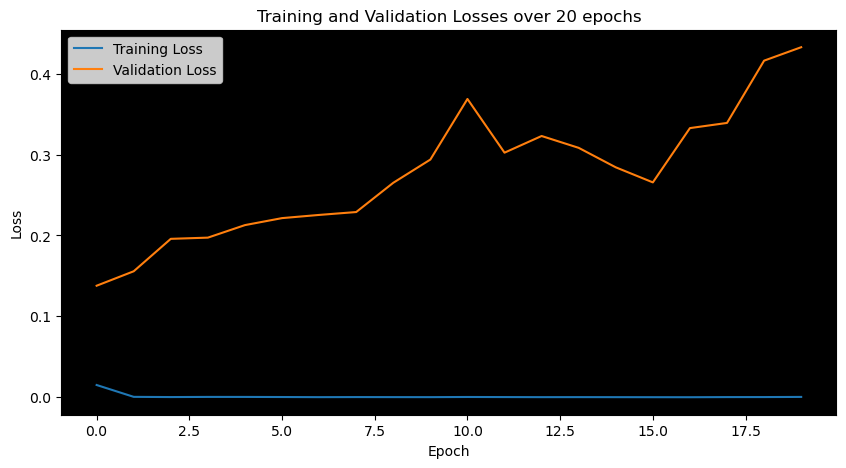

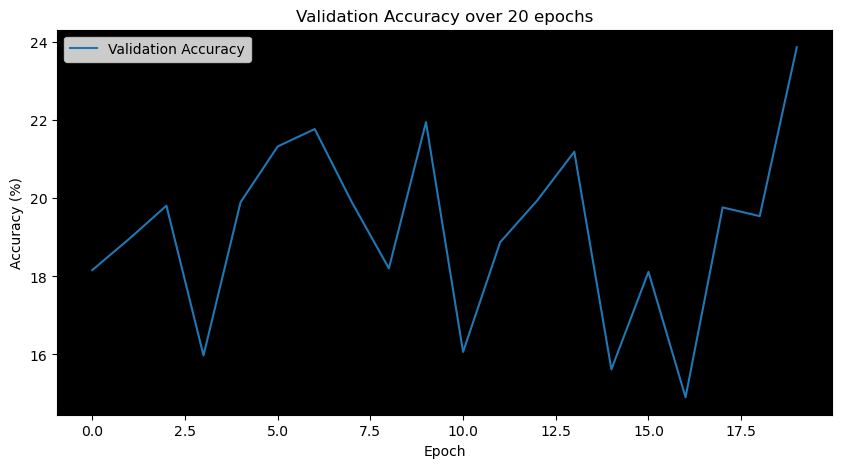

In [40]:
import torch.optim as optim
model5 = SimpleModel(num_channels=3, num_classes=12)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters(), lr=0.001)

train(model5, train_loader, val_loader, criterion, optimizer, num_epochs=20)

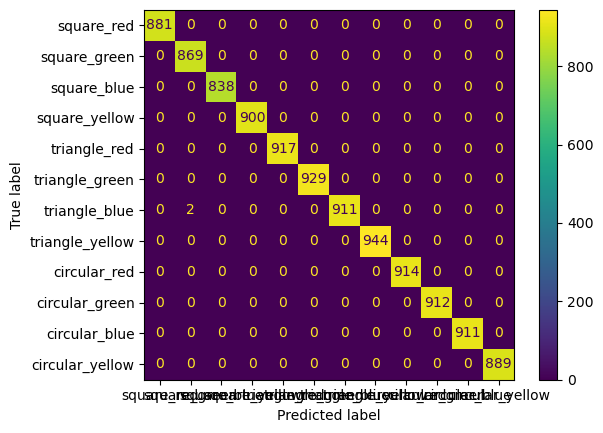

In [41]:
matrix(train_loader, model5, ['square_red', 'square_green', 'square_blue', 'square_yellow', 'triangle_red', 'triangle_green', 'triangle_blue', 'triangle_yellow', 'circular_red', 'circular_green', 'circular_blue', 'circular_yellow'])

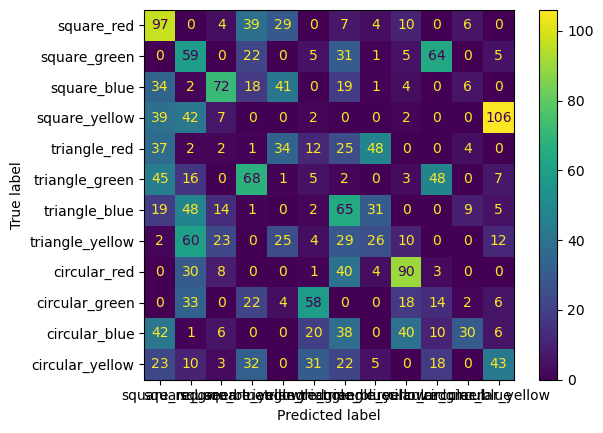

In [42]:
matrix(val_loader, model5, ['square_red', 'square_green', 'square_blue', 'square_yellow', 'triangle_red', 'triangle_green', 'triangle_blue', 'triangle_yellow', 'circular_red', 'circular_green', 'circular_blue', 'circular_yellow'])

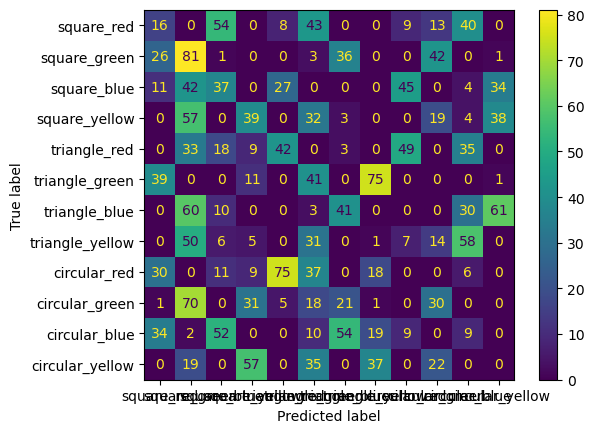

In [43]:
matrix(test_loader, model5, ['square_red', 'square_green', 'square_blue', 'square_yellow', 'triangle_red', 'triangle_green', 'triangle_blue', 'triangle_yellow', 'circular_red', 'circular_green', 'circular_blue', 'circular_yellow'])

In [44]:
from torchvision import transforms
from PIL import Image

train_transform_augmentation = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.RandomVerticalFlip(p=0.1),
    torchvision.transforms.RandomHorizontalFlip(p=0.1),
    torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    torchvision.transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.5, 2)), 
    torchvision.transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)), 
])

train_dataset_augmented = FlyingObjects(root=training_img_dir, fine_grained=True, transform=train_transform_augmentation)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)
print("Train Dataset Length:", len(train_dataset_augmented))

Number of Images Found: 10817
Train Dataset Length: 10817


Data: 10817
Epochs: 50
Start of training.
New maximum validation accuracy: 33.15%, model saved at best_model.pth
1/50 --> Training Loss / per sample = 0.0542071013, Validation Loss / per sample = 0.0577381773, Validation Accuracy = 33.15%
2/50 --> Training Loss / per sample = 0.0375169184, Validation Loss / per sample = 0.0603231220, Validation Accuracy = 29.94%
New maximum validation accuracy: 39.22%, model saved at best_model.pth
3/50 --> Training Loss / per sample = 0.0332689807, Validation Loss / per sample = 0.0583562530, Validation Accuracy = 39.22%
New maximum validation accuracy: 44.89%, model saved at best_model.pth
4/50 --> Training Loss / per sample = 0.0273464865, Validation Loss / per sample = 0.0494437742, Validation Accuracy = 44.89%
New maximum validation accuracy: 56.00%, model saved at best_model.pth
5/50 --> Training Loss / per sample = 0.0230711392, Validation Loss / per sample = 0.0417872274, Validation Accuracy = 56.00%
New maximum validation accuracy: 59.84%, mod

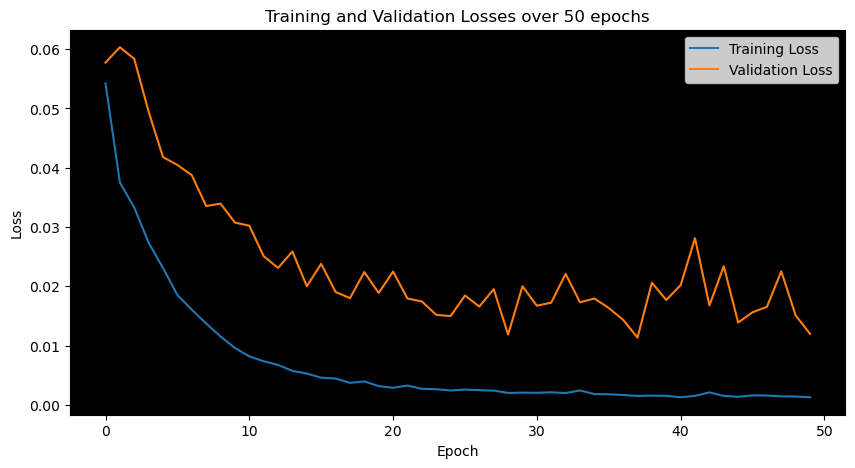

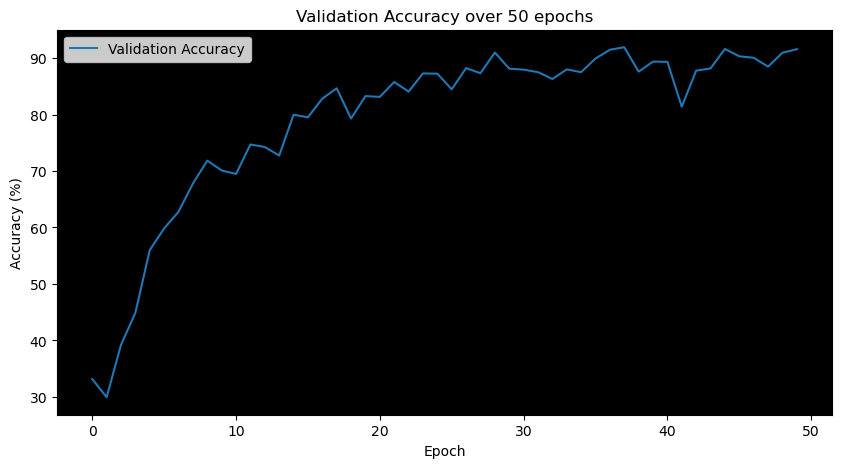

In [45]:
model6 = SimpleModel(num_channels=3, num_classes=12)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model6.parameters(), lr=0.001)

train(model6, train_loader_augmented, val_loader, criterion, optimizer, num_epochs=50)

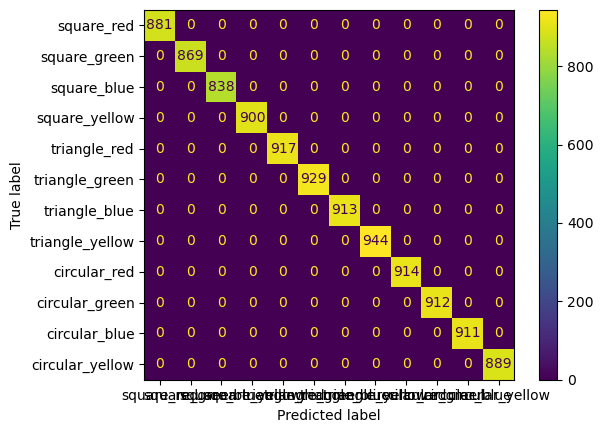

In [46]:
matrix(train_loader, model6, ['square_red', 'square_green', 'square_blue', 'square_yellow', 'triangle_red', 'triangle_green', 'triangle_blue', 'triangle_yellow', 'circular_red', 'circular_green', 'circular_blue', 'circular_yellow'])

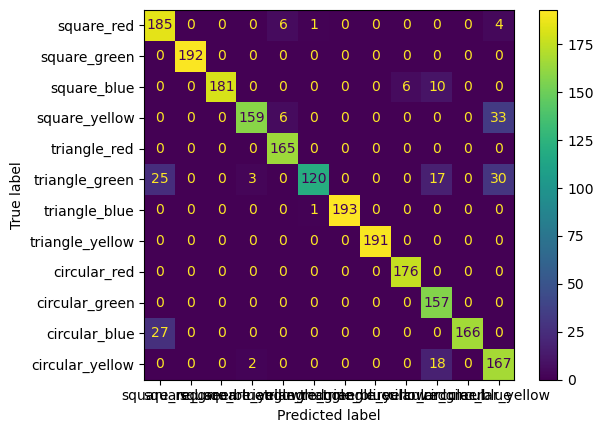

In [47]:
matrix(val_loader, model6, ['square_red', 'square_green', 'square_blue', 'square_yellow', 'triangle_red', 'triangle_green', 'triangle_blue', 'triangle_yellow', 'circular_red', 'circular_green', 'circular_blue', 'circular_yellow'])

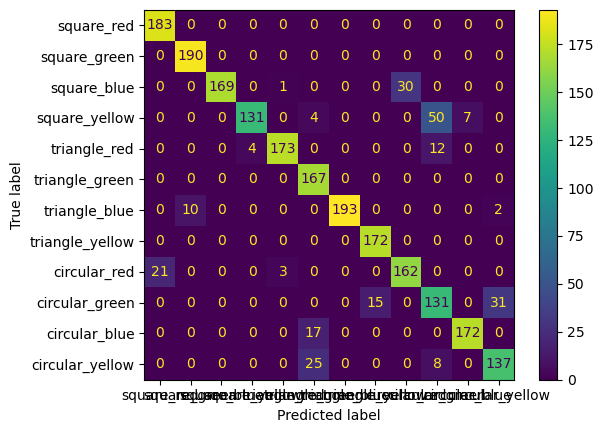

In [48]:
matrix(test_loader, model6, ['square_red', 'square_green', 'square_blue', 'square_yellow', 'triangle_red', 'triangle_green', 'triangle_blue', 'triangle_yellow', 'circular_red', 'circular_green', 'circular_blue', 'circular_yellow'])

# Question 7
Change the model and dataset to predict both shape and color of the flying object separately. Hint: The model may have 2 output heads. One should predict the color and another should predict the shape. Report the changes you made along with the results. 

## Modifications
I had to modify a few things, firstly i had to divide the labels of the dataclass to have 2 labels, one for shape and one for color. In addition to this i had to modify the training function since they only took in an image and its corresponding label, and not 2 labels. now it takes in 2 labels. I also had to modify the model, which was done by adding so that it has 2 heads, one for shape and one for color.

Also, by looking at the results, it looks good. the accuracy curve starts low and stabilizes high.

Within the training function, the loss function also has to be altered, which was done by calculating losses for both the labels, namely, color and shape. After they were calculated individually, the mean of them is then used as the "actual" loss for the model.

In [49]:
import os
import imageio
import numpy as np
import torch

class FlyingObjects2Heads(torch.utils.data.Dataset):
    def __init__(self, root, fine_grained=False, transform=None):
        super(FlyingObjects2Heads, self).__init__()
        self.root = root
        self.transform = transform
        self.fine_grained = fine_grained

        self.images = [os.path.join(self.root, 'image', f) for f in os.listdir(os.path.join(self.root, 'image')) if f.endswith(".png")]
        self.images.sort()

        print("Number of Images Found:", len(self.images))
        
        self.shape_classes = ['square', 'triangle', 'circular'] if self.fine_grained else ['shape']
        self.color_classes = ['red', 'green', 'blue', 'yellow'] if self.fine_grained else ['color']
        
        self.shape_labels = [self.__extract_shape_label(f) for f in self.images]
        self.color_labels = [self.__extract_color_label(f) for f in self.images]
    
    def get_shape_classes(self):
        return self.shape_classes
    
    def get_color_classes(self):
        return self.color_classes
    
    def __extract_shape_label(self, image_file):
        """Extract shape label from image_file name"""
        path, img_name = os.path.split(image_file)
        names = img_name.split(".")[0].split("_")

        currLabel = names[1] if self.fine_grained else names[1].split("-")[0]

        if currLabel in self.shape_classes:
            label = self.shape_classes.index(currLabel)
        else:
            raise ValueError("ERROR: Label " + str(currLabel) + " is not defined for shapes!")
        return label
    
    def __extract_color_label(self, image_file):
        """Extract color label from image_file name"""
        path, img_name = os.path.split(image_file)
        names = img_name.split(".")[0].split("_")

        currLabel = names[2] if self.fine_grained else names[1].split("-")[1]

        if currLabel in self.color_classes:
            label = self.color_classes.index(currLabel)
        else:
            raise ValueError("ERROR: Label " + str(currLabel) + " is not defined for colors!")
        return label
    
    def __getitem__(self, index):
        x = imageio.imread(self.images[index])
        if self.transform:
            x = self.transform(x)
        else:
            x = torch.from_numpy(x)
        x = x.float()
   
        shape_label = self.shape_labels[index]
        color_label = self.color_labels[index]

        return x, shape_label, color_label

    def __len__(self):
        return len(self.images)


In [50]:
# Your code here 
train_transform_augmentation = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.RandomVerticalFlip(p=0.1),
    torchvision.transforms.RandomHorizontalFlip(p=0.1),
    torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    torchvision.transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.5, 2)), 
    torchvision.transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)), 
])

training_set = FlyingObjects2Heads(training_img_dir, fine_grained=True, transform=train_transform_augmentation)
validation_set = FlyingObjects2Heads(validation_img_dir, fine_grained=True, transform=train_transform_augmentation)
testing_set = FlyingObjects2Heads(testing_img_dir, fine_grained=True, transform=train_transform_augmentation)

print(f"data points: train:{len(training_set)} valid:{len(validation_set)} test:{len(testing_set)}")

train_loader = DataLoader(training_set, batch_size=32, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False)
test_loader = DataLoader(testing_set, batch_size=32, shuffle=False)

print(f"nr of batches: train:{len(train_loader)} valid:{len(val_loader)} test:{len(test_loader)}")

print("nr of classes:", 
      "\n train shape :", training_set.get_shape_classes(),
      "\n train Colors:", training_set.get_color_classes(),
      "\n valid shape:", validation_set.get_shape_classes(),
      "\n valid Colors:", validation_set.get_color_classes(),
      "\n test shape:", testing_set.get_shape_classes(),
      "\n test Colors:", testing_set.get_color_classes())

Number of Images Found: 10817
Number of Images Found: 2241
Number of Images Found: 2220
data points: train:10817 valid:2241 test:2220
nr of batches: train:339 valid:71 test:70
nr of classes: 
 train shape : ['square', 'triangle', 'circular'] 
 train Colors: ['red', 'green', 'blue', 'yellow'] 
 valid shape: ['square', 'triangle', 'circular'] 
 valid Colors: ['red', 'green', 'blue', 'yellow'] 
 test shape: ['square', 'triangle', 'circular'] 
 test Colors: ['red', 'green', 'blue', 'yellow']


In [54]:
def train2Heads(model, train_loader, val_loader, criterion_shape, criterion_color, optimizer, num_epochs=10, lr_dropout_prob=0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    train_losses = []
    val_losses = []
    val_accuracies = []   
    max_val_accuracy = 0.0 
    best_model_path = 'best_model.pth'

    print("Data:", len(train_loader.dataset))
    print("Epochs:", num_epochs)
    print("Start of training.")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct_train_shape = 0 
        correct_train_color = 0  
        total_train = 0    

        for batch_idx, (images, shape_labels, color_labels) in enumerate(train_loader):
            images = images.to(device)
            shape_labels = shape_labels.to(device)
            color_labels = color_labels.to(device)

            optimizer.zero_grad()
            shape_output, color_output = model(images)

            shape_loss = criterion_shape(shape_output, shape_labels)
            color_loss = criterion_color(color_output, color_labels)
            total_loss = shape_loss + color_loss

            total_loss.backward()

            if np.random.rand() > lr_dropout_prob:
                optimizer.step()

            epoch_loss += total_loss.item()

            _, predicted_shape = shape_output.max(1)
            _, predicted_color = color_output.max(1)
            correct_train_shape += (predicted_shape == shape_labels).sum().item()
            correct_train_color += (predicted_color == color_labels).sum().item()
            total_train += shape_labels.size(0)

        average_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(average_loss)
        train_accuracy_shape = (correct_train_shape / total_train) * 100
        train_accuracy_color = (correct_train_color / total_train) * 100

        model.eval()
        val_loss = 0.0
        correct_val_shape = 0   
        correct_val_color = 0    
        total_val = 0     

        with torch.no_grad():
            for batch_idx, (images, shape_labels, color_labels) in enumerate(val_loader):
                images = images.to(device)
                shape_labels = shape_labels.to(device)
                color_labels = color_labels.to(device)

                shape_output, color_output = model(images)

                shape_loss = criterion_shape(shape_output, shape_labels)
                color_loss = criterion_color(color_output, color_labels)
                val_loss += (shape_loss + color_loss).item()

                _, predicted_shape = shape_output.max(1)
                _, predicted_color = color_output.max(1)
                correct_val_shape += (predicted_shape == shape_labels).sum().item()
                correct_val_color += (predicted_color == color_labels).sum().item()
                total_val += shape_labels.size(0)

        average_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(average_val_loss)
        val_accuracy_shape = (correct_val_shape / total_val) * 100
        val_accuracy_color = (correct_val_color / total_val) * 100
        val_accuracies.append((val_accuracy_shape + val_accuracy_color) / 2)

        if val_accuracies[-1] > max_val_accuracy:
            max_val_accuracy = val_accuracies[-1]
            torch.save(model.state_dict(), best_model_path)
            print(f"New maximum validation accuracy: {max_val_accuracy:.2f}%, model saved at {best_model_path}")

        print(f"{epoch + 1}/{num_epochs} --> Train Loss = {average_loss:.10f}, Val Loss = {average_val_loss:.10f}, Shape Val Acc = {val_accuracy_shape:.2f}%, Color Val Acc = {val_accuracy_color:.2f}%")

    print("End of training.")
    print("Highest Validation Accuracy:", max_val_accuracy)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Validation Losses over {num_epochs} epochs')
    plt.gca().set_facecolor('black')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title(f'Validation Accuracy over {num_epochs} epochs')
    plt.gca().set_facecolor('black')
    plt.show()

In [52]:
import torch
import torch.nn as nn
from collections import OrderedDict

class SimpleModel2Heads(torch.nn.Module):
    def __init__(self, num_channels, num_shapes, num_colors, input_shape=(128, 128)):
        super(SimpleModel2Heads, self).__init__()
        self.conv_layer1 = self._conv_layer_set(num_channels, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc_common = nn.Linear(64 * input_shape[0] // 4 * input_shape[1] // 4, 64)
        
        self.fc_shape = nn.Linear(64, num_shapes)
        self.fc_color = nn.Linear(64, num_colors)
        
        self.drop = nn.Dropout(0.5)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)),
            ('leakyrelu', nn.LeakyReLU()),
            ('maxpool', nn.MaxPool2d(2)),
        ]))
        return conv_layer
    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        
        out = out.view(out.size(0), -1)
        
        out = self.fc_common(out)
        out = self.drop(out)
        
        shape_out = self.fc_shape(out)
        color_out = self.fc_color(out)
        
        return shape_out, color_out

Data: 10817
Epochs: 50
Start of training.


C:\Users\danie\AppData\Local\Temp\ipykernel_21564\621346868.py:59: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(self.images[index])


New maximum validation accuracy: 54.46%, model saved at best_model.pth
1/50 --> Train Loss = 0.0569279376, Val Loss = 0.0556332210, Shape Val Acc = 29.63%, Color Val Acc = 79.29%
2/50 --> Train Loss = 0.0420697701, Val Loss = 0.0555434083, Shape Val Acc = 32.26%, Color Val Acc = 75.01%
New maximum validation accuracy: 56.96%, model saved at best_model.pth
3/50 --> Train Loss = 0.0391699631, Val Loss = 0.0517009695, Shape Val Acc = 32.44%, Color Val Acc = 81.48%
New maximum validation accuracy: 58.37%, model saved at best_model.pth
4/50 --> Train Loss = 0.0362546050, Val Loss = 0.0540962148, Shape Val Acc = 35.07%, Color Val Acc = 81.66%
New maximum validation accuracy: 60.31%, model saved at best_model.pth
5/50 --> Train Loss = 0.0338023268, Val Loss = 0.0541896062, Shape Val Acc = 38.02%, Color Val Acc = 82.60%
New maximum validation accuracy: 63.83%, model saved at best_model.pth
6/50 --> Train Loss = 0.0305869266, Val Loss = 0.0502002030, Shape Val Acc = 43.15%, Color Val Acc = 84.5

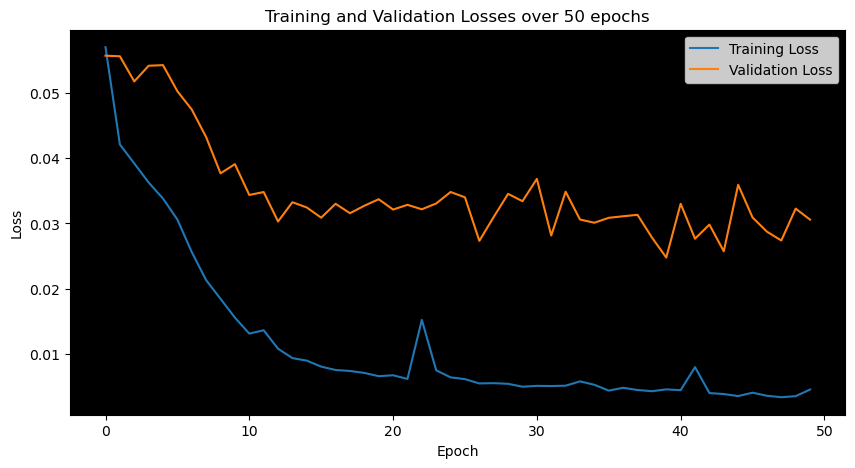

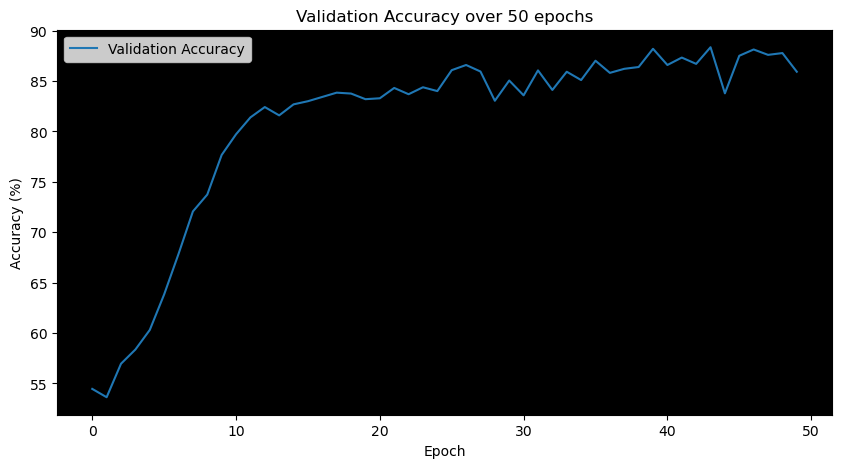

In [53]:
import torch.optim as optim
model6 = SimpleModel2Heads(num_channels=3, num_shapes=len(training_set.get_shape_classes()), num_colors=len(training_set.get_color_classes()))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model6.parameters(), lr=0.001)

train2Heads(model6, train_loader, val_loader, criterion, criterion, optimizer, num_epochs=50)